In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import tensorflow as tf

import draw_model
import draw_mnist

from matplotlib import pyplot as plt

reload(draw_model);
reload(draw_mnist);

In [3]:
mnist = draw_mnist.MnistData()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def get_image(index):
    return np.reshape((mnist._data.train.images[index,:] >= 0.5).astype(np.float32), [28,28])

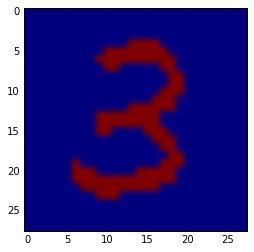

In [5]:
plt.imshow(get_image(11))

In [11]:
def _range1toN(N):
    return tf.cast(tf.range(1, N + 1), dtype=tf.float32)


class AttnModel(object):

    def __init__(self, batch_size,image_height, image_width,
                 patch_height, patch_width):
        image_N = max(image_height, image_width)
        patch_N = max(patch_height, patch_width)
        
        self.x = tf.placeholder(
            dtype=tf.float32, shape=[batch_size, image_height, image_width])
        self.gx = tf.placeholder(dtype=tf.float32, shape=[batch_size])
        self.gy = tf.placeholder(dtype=tf.float32, shape=[batch_size])
        self.log_sigma2 = tf.placeholder(dtype=tf.float32, shape=[batch_size])
        self.log_delta = tf.placeholder(dtype=tf.float32, shape=[batch_size])
        self.log_gamma = tf.placeholder(dtype=tf.float32, shape=[batch_size])
        
        gx = tf.expand_dims(self.gx, 1)
        gy = tf.expand_dims(self.gy, 1)
        log_sigma2 = tf.expand_dims(self.log_sigma2, 1)
        log_delta = tf.expand_dims(self.log_delta, 1)
        log_gamma = tf.expand_dims(self.log_gamma, 1)
        
        gx = (image_width + 1.0) / 2.0 * (gx + 1.0)
        gy = (image_height + 1.0) / 2.0 * (gy + 1.0)
        sigma2 = tf.exp(log_sigma2)
        delta = (image_N - 1.0) / (patch_N - 1.0) * tf.exp(log_delta)
        gamma = tf.exp(log_gamma)
            
        def compute_F(a_g, a_patch_D, a_image_D):
            # batch_size x patch_D
            mu = a_g + (_range1toN(a_patch_D) - a_patch_D / 2.0 - 0.5) * delta
            # batch_size x patch_D x 1
            mu = tf.expand_dims(mu, 2)
                
            # batch_size x patch_D x image_D
            F = _range1toN(a_image_D) - mu
            F = - F * F / 2.0 / tf.expand_dims(sigma2, 2)
            F_shape = F.get_shape()
            F = tf.reshape(F, [-1, a_image_D])
            F = tf.nn.softmax(F)
            F = tf.reshape(F, F_shape)
                
            return F
            
        # batch_size x patch_width x image_width
        Fx = compute_F(gx, patch_width, image_width)
        # batch_size x patch_height x image_height
        Fy = compute_F(gy, patch_height, image_height)
            
        self.gamma = tf.expand_dims(gamma, 2)
        self.Fx = Fx
        self.Fy = Fy
        
        self.patch = self.gamma * tf.batch_matmul(tf.batch_matmul(Fy, self.x), Fx, adj_y=True)
        self.xp = tf.batch_matmul(tf.batch_matmul(Fy, self.patch, adj_x=True), Fx) / self.gamma

In [19]:
img = get_image(11)

with tf.Graph().as_default(), tf.Session() as sess:
    with tf.variable_scope("attn_model"):
        a = AttnModel(1, 28, 28, 12, 12)
    feed_dict = {
        a.x : np.expand_dims(img, 0),
        a.gx : [0.0],
        a.gy : [0.0],
        a.log_sigma2 : [0.0],
        a.log_delta : [-0.8],
        a.log_gamma : [0.0]
    }
    
    Fx, Fy, patch, xp = sess.run([a.Fx, a.Fy, a.patch, a.xp], feed_dict=feed_dict)
    Fx = np.squeeze(Fx, 0)
    Fy = np.squeeze(Fy, 0)
    patch = np.squeeze(patch, 0)
    xp = np.squeeze(xp, 0)

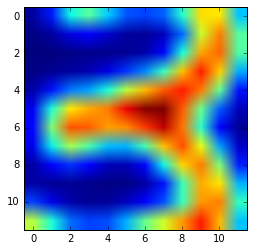

In [20]:
plt.imshow(patch)

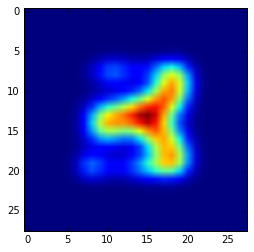

In [21]:
plt.imshow(xp)

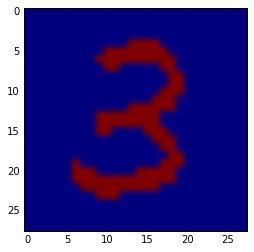

In [18]:
plt.imshow(img)

In [100]:
patch

array([[  9.56979468e-02,   2.45334536e-01,   3.58097047e-01,
          3.95387173e-01,   2.65000522e-01,   7.76488408e-02,
          9.68892500e-03,   6.69515925e-04,   3.41640844e-05,
          1.51740710e-06],
       [  8.62200484e-02,   2.15887755e-01,   3.43295068e-01,
          4.18478698e-01,   2.89625019e-01,   8.52285102e-02,
          1.06390910e-02,   7.35789537e-04,   3.75883319e-05,
          1.67121675e-06],
       [  1.32116199e-01,   2.96232611e-01,   4.32726979e-01,
          4.57959503e-01,   2.63120264e-01,   6.54589459e-02,
          7.17507862e-03,   4.50613676e-04,   2.14461234e-05,
          9.05576542e-07],
       [  1.57195956e-01,   2.58710355e-01,   3.56425941e-01,
          4.18946475e-01,   2.67168075e-01,   7.10339919e-02,
          8.09239782e-03,   5.19793946e-04,   2.50859193e-05,
          1.06909829e-06],
       [  2.57877141e-01,   3.15881133e-01,   3.64382029e-01,
          4.11020219e-01,   2.70021111e-01,   7.53619224e-02,
          8.97151791e-03

In [101]:
Fx

array([[  4.19590622e-03,   1.04606692e-02,   2.27781162e-02,
          4.33212258e-02,   7.19628558e-02,   1.04409650e-01,
          1.32311493e-01,   1.46446526e-01,   1.41574562e-01,
          1.19540758e-01,   8.81599784e-02,   5.67873418e-02,
          3.19489203e-02,   1.56994928e-02,   6.73813140e-03,
          2.52591097e-03,   8.27029988e-04,   2.36509833e-04,
          5.90747077e-05,   1.28878091e-05,   2.45572983e-06,
          4.08702419e-07,   5.94098140e-08,   7.54280993e-09,
          8.36437863e-10,   8.10137235e-11,   6.85342798e-12,
          5.06386708e-13],
       [  1.19974007e-04,   4.48897306e-04,   1.46700430e-03,
          4.18736367e-03,   1.04393726e-02,   2.27317419e-02,
          4.32330258e-02,   7.18163475e-02,   1.04197077e-01,
          1.32042110e-01,   1.46148369e-01,   1.41286328e-01,
          1.19297385e-01,   8.79804865e-02,   5.66717274e-02,
          3.18838730e-02,   1.56675298e-02,   6.72441302e-03,
          2.52076820e-03,   8.25346156e-04,

In [102]:
Fy

array([[  4.19590622e-03,   1.04606692e-02,   2.27781162e-02,
          4.33212258e-02,   7.19628558e-02,   1.04409650e-01,
          1.32311493e-01,   1.46446526e-01,   1.41574562e-01,
          1.19540758e-01,   8.81599784e-02,   5.67873418e-02,
          3.19489203e-02,   1.56994928e-02,   6.73813140e-03,
          2.52591097e-03,   8.27029988e-04,   2.36509833e-04,
          5.90747077e-05,   1.28878091e-05,   2.45572983e-06,
          4.08702419e-07,   5.94098140e-08,   7.54280993e-09,
          8.36437863e-10,   8.10137235e-11,   6.85342798e-12,
          5.06386708e-13],
       [  1.19974007e-04,   4.48897306e-04,   1.46700430e-03,
          4.18736367e-03,   1.04393726e-02,   2.27317419e-02,
          4.32330258e-02,   7.18163475e-02,   1.04197077e-01,
          1.32042110e-01,   1.46148369e-01,   1.41286328e-01,
          1.19297385e-01,   8.79804865e-02,   5.66717274e-02,
          3.18838730e-02,   1.56675298e-02,   6.72441302e-03,
          2.52076820e-03,   8.25346156e-04,